# Forecasting life expectancy up to 2030 using data from 1970 to 2017

In [19]:
# import packages
import os 
import numpy as np 
import pandas as pd
from pandas import to_datetime
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.metrics import mean_squared_error
import pystan
from fbprophet import Prophet

import itertools
import warnings

import datetime
from datetime import datetime
warnings.filterwarnings('ignore')

# Increases the size of sns plots
sns.set(rc={'figure.figsize':(8,6)})

In [2]:
# import data 

df_original = pd.read_csv('/Users/nadiaparsell/csv_files/WHO_indicators.csv')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df = df_original.copy()

df.head()

,demo_ind,Indicator,location,country,time,value,flag codes,flags
0,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1970,2.86,NaN,NaN
1,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1971,2.96,NaN,NaN
2,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1972,2.74,NaN,NaN
3,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1973,2.49,NaN,NaN
4,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1974,2.40,NaN,NaN


In [4]:
# Indicators 

df['Indicator'].value_counts()

Total population                                                            11262
Population aged 14 years or younger                                         11262
Population aged 15-24 years                                                 11262
Population aged 65 years or older                                           11262
Population aged 25-64 years                                                 11262
Population growth (annual %)                                                10281
Rural population (% of total population)                                    10274
Official exchange rate (LCU per US$, period average)                         9469
Fertility rate, total (births per woman)                                     9411
Life expectancy at birth, total (years)                                      9395
GDP (current LCU)                                                            8903
DEC alternative conversion factor (LCU per US$)                              8888
Mortality rate, 

In [5]:
# check data types 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270038 entries, 0 to 270037
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   demo_ind    270038 non-null  object 
 1   Indicator   270038 non-null  object 
 2   location    270038 non-null  object 
 3   country     270038 non-null  object 
 4   time        270038 non-null  int64  
 5   value       267972 non-null  float64
 6   flag codes  2066 non-null    object 
 7   flags       2066 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 16.5+ MB


Years are currently objects so lets turn that into datetime 

In [6]:
# change to datetime 

df['time'] = df['time'].astype(str) + '-01-01'
df['time'] = pd.to_datetime(df['time'])

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270038 entries, 0 to 270037
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   demo_ind    270038 non-null  object        
 1   Indicator   270038 non-null  object        
 2   location    270038 non-null  object        
 3   country     270038 non-null  object        
 4   time        270038 non-null  datetime64[ns]
 5   value       267972 non-null  float64       
 6   flag codes  2066 non-null    object        
 7   flags       2066 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 16.5+ MB


Now it is in datetime 

In [8]:
# look at what years we have time data for 

df['time'].unique()

array(['1970-01-01T00:00:00.000000000', '1971-01-01T00:00:00.000000000',
       '1972-01-01T00:00:00.000000000', '1973-01-01T00:00:00.000000000',
       '1974-01-01T00:00:00.000000000', '1975-01-01T00:00:00.000000000',
       '1976-01-01T00:00:00.000000000', '1977-01-01T00:00:00.000000000',
       '1978-01-01T00:00:00.000000000', '1979-01-01T00:00:00.000000000',
       '1980-01-01T00:00:00.000000000', '1981-01-01T00:00:00.000000000',
       '1982-01-01T00:00:00.000000000', '1983-01-01T00:00:00.000000000',
       '1984-01-01T00:00:00.000000000', '1985-01-01T00:00:00.000000000',
       '1986-01-01T00:00:00.000000000', '1987-01-01T00:00:00.000000000',
       '1988-01-01T00:00:00.000000000', '1989-01-01T00:00:00.000000000',
       '1990-01-01T00:00:00.000000000', '1991-01-01T00:00:00.000000000',
       '1992-01-01T00:00:00.000000000', '1993-01-01T00:00:00.000000000',
       '1994-01-01T00:00:00.000000000', '1995-01-01T00:00:00.000000000',
       '1996-01-01T00:00:00.000000000', '1997-01-01

1970 to 2019

In [9]:
# create new dataframe with only data on life expectancy at birth 

le_df = df[df['Indicator'] == 'Life expectancy at birth, total (years)']

# check for null values 
le_df.isna().sum()

demo_ind         0
Indicator        0
location         0
country          0
time             0
value            0
flag codes    9395
flags         9395
dtype: int64

In [24]:
# Just keep country, year, and life expectacy at birth

le_df = le_df[['country','time','value']]
le_df.head()

,country,time,value
7790,Australia,1970-01-01,71.02
7791,Australia,1971-01-01,71.07
7792,Australia,1972-01-01,71.46
7793,Australia,1973-01-01,71.85
7794,Australia,1974-01-01,72.24


<AxesSubplot:xlabel='time', ylabel='value'>

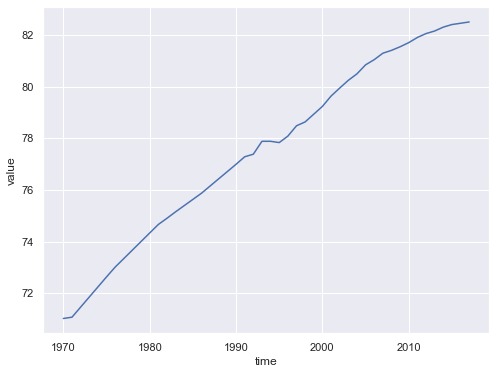

In [27]:
aus_df = le_df[le_df['country'] == 'Australia']
sns.lineplot(data=aus_df, x='time', y='value')

Life expectancy at birth is increasing over time 

In [31]:
# split into training and testing data

X_train = le_df[le_df['time'] < '2012-01-01']
X_valid = le_df[le_df['time'] >= '2011-01-01']

# Create a function that uses prophet to forecast life expectancy up to 2030

First train the model using data from 1970 to 2011, and use the model to predict life expectancy between 2011 and 2017. Check the accuracy using mean squared errors

Next, train the model with all of the data (1970 to 2030) in order to make predictions up to 2030. 

In [50]:
# Create a time series function 

def life_exp(countries, df):
    for c in countries:
        #################### predict life expectancy between 2010-2017 ###########
        # training data
        train = X_train[X_train['country'] == c]
        train2 = train[['time','value']]

        # actual data
        actual_data = X_valid[X_valid['country'] == c]
        actual_data2 = actual_data[['time','value']]

        # rename columns for prophet model 
        train2.columns = ['ds','y']
        actual_data2.columns = ['ds','y']

        # set time as the index
        actual_data2.set_index('ds', inplace=True)

        # turn from dataframe into series
        actual_data2 = actual_data2.squeeze()
        actual_data2 = actual_data2.rename('Actual data')

        # define the model
        model = Prophet()

        # fit the model 
        model.fit(train2)

        # years we want predictions
        index_7_years = pd.date_range(start = '2011-01-01', freq='AS', periods=7)
        df_index_7_years = pd.DataFrame(index_7_years)
        df_index_7_years.columns = ['ds']

        # use the model to make a forecast
        fcast = model.predict(df_index_7_years)
        fcast = pd.Series(fcast['yhat'].values, index=index_7_years)
        fcast = fcast.rename('Forecast from 2011-17')

        # Printing the AI
        print('The MSE of prophet for ' + c + ' is:', mean_squared_error(actual_data['value'].values, fcast, squared=False))

        ######################### Future prediction #################################
        # Setting the Future - Index for 14 years
        future_index_14_years = pd.date_range(start = '2017-01-01', freq='AS', periods = 14)

        # train with all of the data 
        all_data = df[df['country'] == c]
        all_data = all_data[['time','value']]
        all_data.columns = ['ds','y']

        # define the model
        model2 = Prophet()

        # fit the model
        model2.fit(all_data)

        # define the period for which we want a prediction - Future
        f_df_index_14_years = pd.DataFrame(future_index_14_years)
        f_df_index_14_years.columns = ['ds']
        f_df_index_14_years['ds']= to_datetime(f_df_index_14_years['ds'])


        # use the model to make a forecast
        f_fcast = model2.predict(f_df_index_14_years)
        f_fcast = pd.Series(f_fcast['yhat'].values, index=future_index_14_years)
        f_fcast = f_fcast.rename("Forecast from 2017-30") 

        ########################## plotting the predictions #############################

        fig, ax = plt.subplots(figsize=(10,5))
        chart = sns.lineplot(x='time', y='value', data=train)
        chart.set_title(c)
        actual_data2.plot(ax=ax, color='blue', marker='o', legend=True)
        fcast.plot(ax=ax, color='red', marker='o', legend=True)
        f_fcast.plot(ax=ax, color='green', marker="v", legend=True)
        chart.set(xlabel='Time', ylabel='Life expectancy (years)')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The MSE of prophet for Australia is: 0.47229675687454553


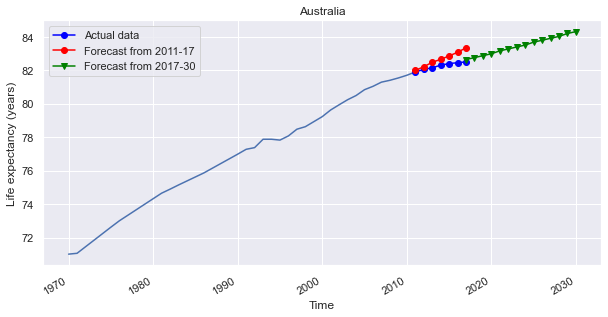

In [51]:
# First, forecast on Australia

countries = ['Australia']
life_exp(countries, le_df)

In [29]:
# find the countries with the lowest life expectancy in the most recent year (2017)

# filter
filt = le_df['time'] == '2017-01-01'

# find the top ten countries with the lowest life expectancy in 2017
le_df[filt].sort_values(by='value')[:5]

,country,time,value
14749,Sierra Leone,2017-01-01,52.21
10306,Central African Republic,2017-01-01,52.89
10354,Chad,2017-01-01,53.21
14082,Nigeria,2017-01-01,53.88
10690,Côte d'Ivoire,2017-01-01,54.10


In [12]:
# top five countries with the lowest life expectancy as of 2017

lowest_le = ['Sierra Leone', 'Central African Republic','Chad','Nigeria',"Côte d'Ivoire"]

lowest_le_df = le_df.loc[le_df['country'].isin(lowest_le)]

In [13]:
# find the top five countries with the highest life expectancy in 2017
le_df[filt].sort_values(by='value', ascending=False)[:5]

,country,time,value
12159,"China, Hong Kong Special Administrative Region",2017-01-01,84.68
8509,Japan,2017-01-01,84.10
15469,"China, Macao Special Administrative Region",2017-01-01,83.99
161732,Switzerland,2017-01-01,83.60
170808,Spain,2017-01-01,83.33


In [14]:
# countries with the highest life expectancy as of 2017 

highest_le = ['China, Hong Kong Special Administrative Region','Japan','China, Macao Special Administrative Region',
             'Switzerland','Spain']
highest_le_df = le_df.loc[le_df['country'].isin(highest_le)]

# Forecast life expectancy for countries with the lowest life expectancy as of 2017

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The MSE of prophet for Sierra Leone is: 1.457926569394763


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The MSE of prophet for Central African Republic is: 1.303602228220032


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The MSE of prophet for Chad is: 0.7683566287920445


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The MSE of prophet for Nigeria is: 0.3558606472505901


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The MSE of prophet for Côte d'Ivoire is: 0.215718643544378


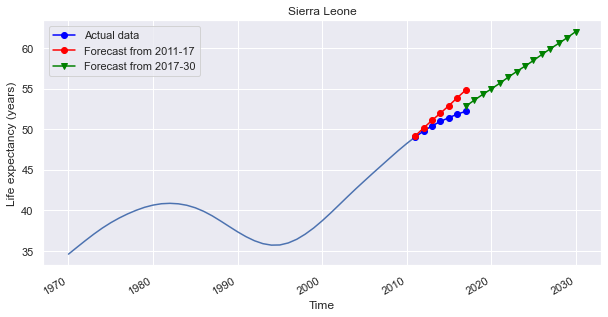

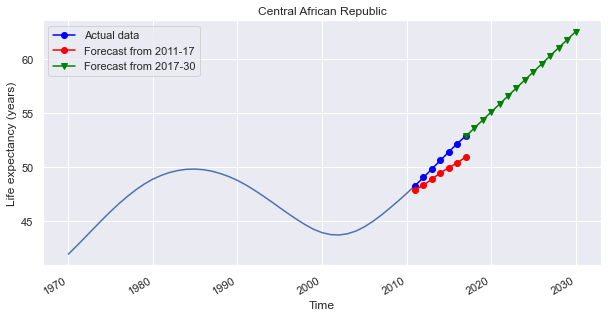

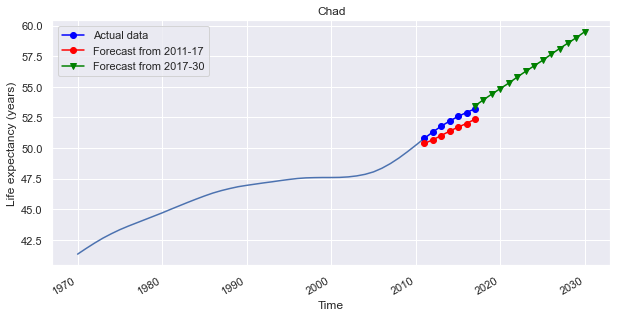

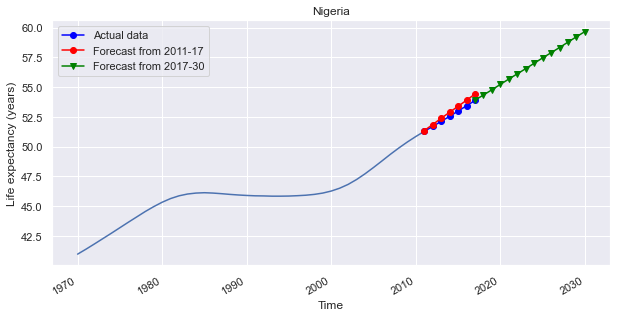

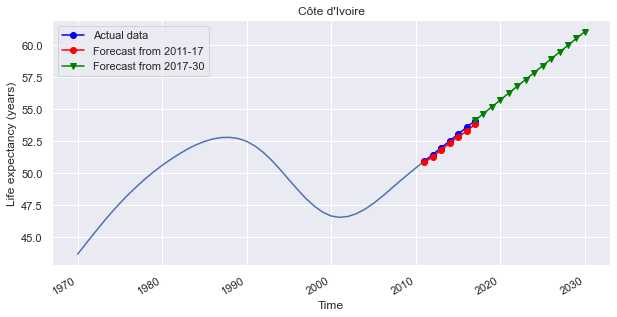

In [52]:
life_exp(lowest_le, lowest_le_df)

# Forecast life expectancy for countries with the highest life expectancy as of 2017

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The MSE of prophet for China, Hong Kong Special Administrative Region is: 0.17600518015652875


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The MSE of prophet for Japan is: 0.22105340621034858


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The MSE of prophet for China, Macao Special Administrative Region is: 0.15591749027021504


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The MSE of prophet for Switzerland is: 0.4210959319435143


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The MSE of prophet for Spain is: 0.38056197765900907


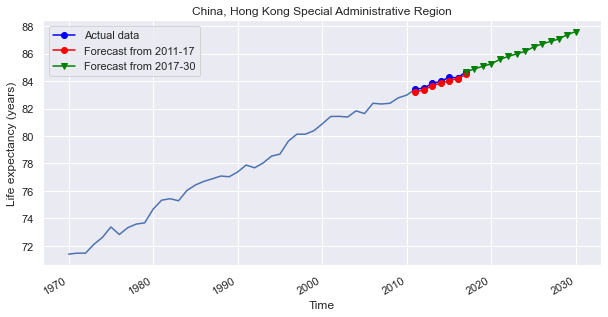

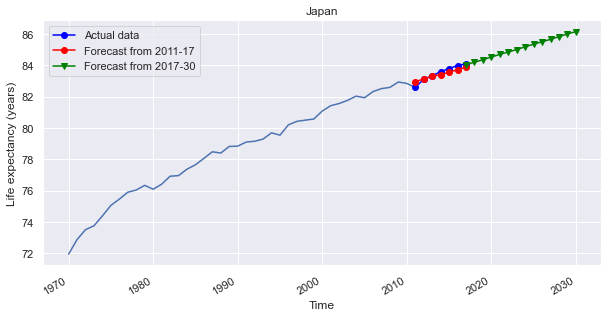

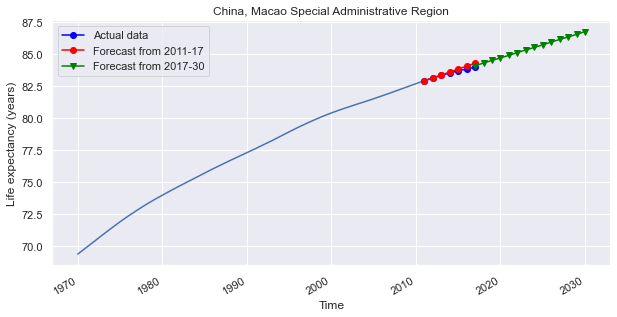

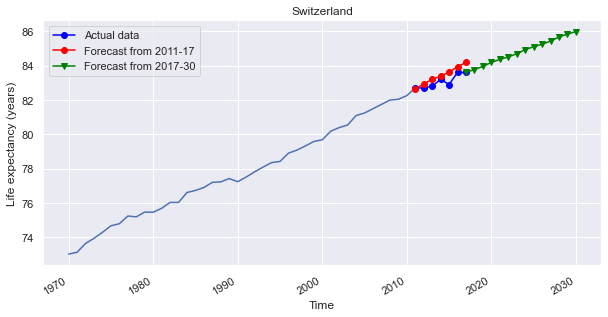

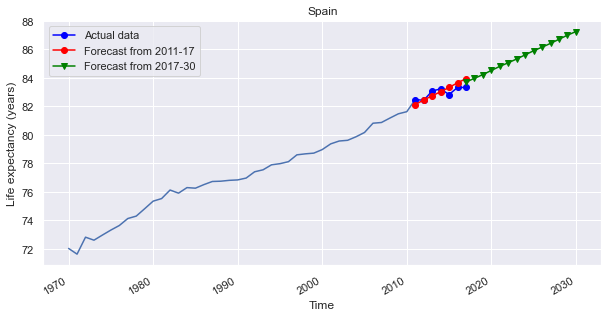

In [53]:
life_exp(highest_le, highest_le_df)